In [3]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [9]:
class MeanTest:
    def __init__(self, df):
        self.df = df

    # 단일표본 검정
    def single_sample_test(self, population_mean):
        results = []
        
        # 정규성 검정 (Shapiro-Wilk Test)
        shapiro_test = stats.shapiro(self.df['value'])
        results.append(f"Step1(Shapiro-Wilk) - Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")
        
        if shapiro_test.pvalue < 0.05:
            # 정규성 검정을 만족하지 못한 경우
            wilcoxon_test = stats.wilcoxon(self.df['value'] - population_mean)
            results.append("----------\nPrior Test - Normality X\nResult(Wilcoxon signed-rank test) - Statistic: {:.4f}, p-value: {:.4f}".format(wilcoxon_test.statistic, wilcoxon_test.pvalue))
        else:
            # 정규성 검정을 만족한 경우
            t_test = stats.ttest_1samp(self.df['value'], population_mean)
            results.append("----------\nPrior Test - Normality O\nResult(Single sample t-test) - Statistic: {:.4f}, p-value: {:.4f}".format(t_test.statistic, t_test.pvalue))
        
        return results

    # 대응표본 검정
    def paired_samples_test(self):
        results = []
        
        group1 = self.df[self.df['group'] == self.df['group'].unique()[0]]['value'].reset_index(drop=True)
        group2 = self.df[self.df['group'] == self.df['group'].unique()[1]]['value'].reset_index(drop=True)
        
        if len(group1) != len(group2):
            raise ValueError("Paired tests require both groups to have the same number of observations.")
        
        # 정규성 검정 (Shapiro-Wilk Test)
        shapiro_group1 = stats.shapiro(group1)
        shapiro_group2 = stats.shapiro(group2)
        
        results.append(f"Step1(Shapiro-Wilk for group1) - Statistic: {shapiro_group1.statistic:.4f}, p-value: {shapiro_group1.pvalue:.4f}")
        results.append(f"Step1(Shapiro-Wilk for group2) - Statistic: {shapiro_group2.statistic:.4f}, p-value: {shapiro_group2.pvalue:.4f}")
        
        if shapiro_group1.pvalue < 0.05 or shapiro_group2.pvalue < 0.05:
            # 정규성 검정을 만족하지 못한 경우
            wilcoxon_test = stats.wilcoxon(group1, group2)
            results.append(f"----------\nPrior Test - Normality X\nResult(Wilcoxon signed-rank test) - Statistic: {wilcoxon_test.statistic:.4f}, p-value: {wilcoxon_test.pvalue:.4f}")
        else:
            # 정규성 검정을 만족한 경우
            paired_t_test = stats.ttest_rel(group1, group2)
            results.append(f"----------\nPrior Test - Normality O\nResult(Paired sample t-test) - Statistic: {paired_t_test.statistic:.4f}, p-value: {paired_t_test.pvalue:.4f}")
        
        return results
    
    # 독립표본 검정
    def independent_samples_test(self):
        results = []
        
        group1 = self.df[self.df['group'] == self.df['group'].unique()[0]]['value'].reset_index(drop=True)
        group2 = self.df[self.df['group'] == self.df['group'].unique()[1]]['value'].reset_index(drop=True)
        
        # 독립성 검정 (상관 검정 사용)
        correlation_test = stats.pearsonr(group1, group2)
        results.append(f"Step1(Pearson) - Statistic: {correlation_test[0]:.4f}, p-value: {correlation_test[1]:.4f}")
        
        if correlation_test.pvalue < 0.05:
            # 독립성 검정을 만족하지 못한 경우 (상관관계가 유의미한 경우)
            results.append(f"----------\nPrior Test - Independence X\nResult - Nan")

        else:
            # 독립성 검정을 만족한 경우 (상관관계가 유의미하지 않은 경우)
            # 정규성 검정 (Shapiro-Wilk Test)
            shapiro_group1 = stats.shapiro(group1)
            shapiro_group2 = stats.shapiro(group2)
            
            results.append(f"Step2(Shapiro-Wilk for group1) - Statistic: {shapiro_group1.statistic:.4f}, p-value: {shapiro_group1.pvalue:.4f}")
            results.append(f"Step2(Shapiro-Wilk for group2) - Statistic: {shapiro_group2.statistic:.4f}, p-value: {shapiro_group2.pvalue:.4f}")
            
            if (shapiro_group1.pvalue < 0.05 or shapiro_group2.pvalue < 0.05) and (len(group1) < 30 or len(group2) < 30):
                # 정규성 검정을 만족하지 못하고 표본 크기가 30 미만인 경우
                mann_whitney_u_test = stats.mannwhitneyu(group1, group2)
                results.append(f"----------\nPrior Test - Independence O / Nomrmality X\n Result(Mann-Whitney U test) - Statistic: {mann_whitney_u_test.statistic:.4f}, p-value: {mann_whitney_u_test.pvalue:.4f}")

            else:
                # 정규성 검정을 만족한 경우 또는 표본 크기가 30 이상인 경우
                levene_test = stats.levene(group1, group2)
                results.append(f"Step3(Levene’s) - Statistic: {levene_test.statistic:.4f}, p-value: {levene_test.pvalue:.4f}")
                
                if levene_test.pvalue < 0.05:
                    # 등분산성을 만족하지 못한 경우
                    welch_t_test = stats.ttest_ind(group1, group2, equal_var=False)
                    results.append(f"----------\nPrior Test - Independence O / Nomrmality O / Equal Variance X\nResult(Welch t-test) - Statistic: {welch_t_test.statistic:.4f}, p-value: {welch_t_test.pvalue:.4f}")

                else:
                    # 등분산성을 만족한 경우
                    independent_t_test = stats.ttest_ind(group1, group2, equal_var=True)
                    results.append(f"----------\nPrior Test - Independence O / Nomrmality O / Equal Variance O\nResult(Independent samples t-test) - Statistic: {independent_t_test.statistic:.4f}, p-value: {independent_t_test.pvalue:.4f}")
        
        return results

    def bar_plot(self, title=None, estimator=np.mean):
        # group 컬럼이 존재하는지 확인
        if 'group' in self.df.columns:
            # 두 그룹명을 추출합니다.
            group1_name = self.df['group'].unique()[0]
            group2_name = self.df['group'].unique()[1]
            
            # 막대 그래프
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.barplot(x='group', y='value', data=df, estimator=estimator, ci='sd', ax=ax)
        else:
            # group 컬럼이 없는 경우, 단일 그룹으로 처리
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.barplot(x=np.repeat('Sample', len(df)), y='value', data=df, estimator=estimator, ci='sd', ax=ax)
        
        # 제목
        if title:
            plt.title(title)
        
        plt.show()

Step1(Pearson) - Statistic: -0.0732, p-value: 0.9069
Step2(Shapiro-Wilk for group1) - Statistic: 0.9917, p-value: 0.9854
Step2(Shapiro-Wilk for group2) - Statistic: 0.9900, p-value: 0.9796
Step3(Levene’s) - Statistic: 0.0351, p-value: 0.8561
----------
Prior Test - Independence O / Nomrmality O / Equal Variance O
Result(Independent samples t-test) - Statistic: -6.1654, p-value: 0.0003


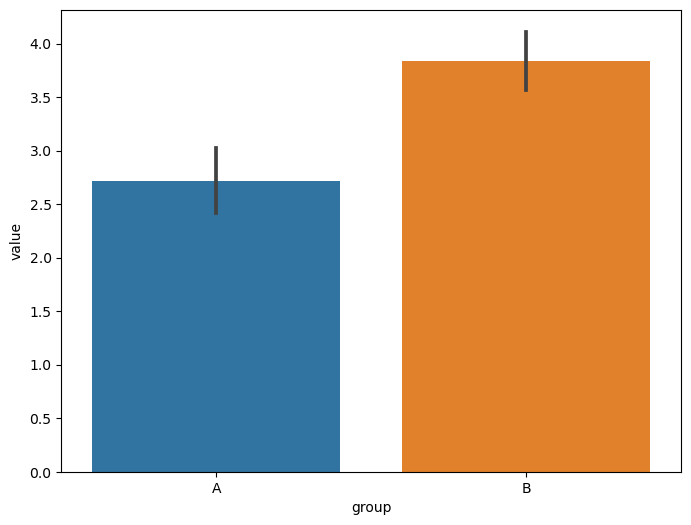

In [12]:
# 예시 데이터
data = {
    'group': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B'],
    'value': [2.3, 3.1, 2.9, 2.6, 2.7, 3.8, 4.0, 3.5, 4.2, 3.7]
}

df = pd.DataFrame(data)

meantest = MeanTest(df)
results = meantest.independent_samples_test()

for result in results:
    print(result)

meantest.bar_plot()